In [21]:
%matplotlib inline
import os
import gzip
import ujson as json
from itertools import islice, takewhile
from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict
import random
import json
import numpy
import pandas as pd

In [2]:
from mimo.evaluate import iter_instance_decodes, evaluate_decodes, get_summary_metrics

ImportError: No module named 'mimo'

In [3]:
data_path = '../data/results/mentions/'

In [4]:
relation_name_map = {
    'country of citizenship': 'citizenship',
    'member of sports team': 'sports team',
    'member of political party': 'political party'
}

relation_order = ['<'+r.replace(' ', '_')+'>' for r in [
    'sex or gender',
    'date of birth',
    'occupation',
    'given name',
    'country of citizenship',
    'place of birth',
    'date of death',
    'place of death',
    'educated at',
    'sport',
    'member of sports team',
    'position held',
    'award received',
    'family name',
    'participant of',
    'member of political party',
]]

### Precision Evaluation

In [14]:
def iter_entity_decodes(path):
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in tqdm(f):
            yield json.loads(line)['decode']

metrics = evaluate_decodes(iter_entity_decodes(os.path.join(data_path, 'output.jsonl.gz')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [15]:
from collections import defaultdict
import numpy


def print_latex_evaluation(metrics):
    systems = ['base', 'sys@1', 'sys@5']
    micro_scores = defaultdict(list)
    macro_scores = defaultdict(list)
    print('\\hline\\hline')
    for r, system_scores in sorted(metrics.items(), key=lambda kv: relation_order.index(kv[0])):
        r_fmt = r.replace('<', '').replace('>', '').replace('_', ' ')
        r_fmt = relation_name_map.get(r_fmt, r_fmt)
        r_fmt = '\\texttt{' + r_fmt + '}'
        
        report = r_fmt.rjust(25)
        
        N = len(system_scores[systems[0]])
        report += ' & ' + "{:,}".format(N).rjust(6)

        for s, scores in [(s, system_scores[s]) for s in systems]:
            score = numpy.mean(scores)
            micro_scores[s].extend(scores)
            macro_scores[s].append(score)
            report += ' & ' + ('%.1f' % (100 * score)).rjust(4)
        print(report + ' \\\\')
    print('\\hline\\hline')
    print('\\multicolumn{2}{r}{\\texttt{Micro Avg.}}'.rjust(25+9) + ' & ' + ' & '.join(('%.1f' % (100 * numpy.mean(micro_scores[s]))).ljust(4) for s in systems) + ' \\\\')
    print('\\multicolumn{2}{r}{\\texttt{Macro Avg.}}'.rjust(25+9) + ' & ' + ' & '.join(('%.1f' % (100 * numpy.mean(macro_scores[s]))).ljust(4) for s in systems) + ' \\\\')
    print('\\hline')
print_latex_evaluation(metrics)

\hline\hline
   \texttt{sex or gender} & 139,272 & 83.5 & 94.2 & 99.0 \\
   \texttt{date of birth} & 118,414 &  0.2 & 75.4 & 80.5 \\
      \texttt{occupation} & 111,462 & 11.8 & 69.8 & 88.1 \\
      \texttt{given name} & 110,770 &  3.4 & 88.0 & 94.1 \\
     \texttt{citizenship} & 102,246 & 28.1 & 89.2 & 94.7 \\
  \texttt{place of birth} & 81,324 &  1.5 & 25.7 & 36.9 \\
   \texttt{date of death} & 55,610 &  0.1 & 68.3 & 75.4 \\
  \texttt{place of death} & 27,618 &  3.8 & 27.8 & 39.2 \\
     \texttt{educated at} & 25,633 &  3.7 & 16.3 & 33.0 \\
           \texttt{sport} & 23,067 & 56.9 & 87.1 & 98.1 \\
     \texttt{sports team} & 21,841 &  0.5 & 17.0 & 31.3 \\
   \texttt{position held} & 13,953 &  6.3 & 63.0 & 78.8 \\
  \texttt{award received} & 12,196 &  4.6 & 38.8 & 56.6 \\
     \texttt{family name} & 11,368 &  4.4 & 61.5 & 70.4 \\
  \texttt{participant of} & 11,054 &  6.3 & 44.5 & 81.1 \\
 \texttt{political party} & 10,409 & 18.3 & 60.6 & 83.8 \\
\hline\hline
\multicolumn{2}{r}{\textt

### Inspecting model output

In [9]:
instances = {}
with gzip.open(os.path.join(data_path, 'output.jsonl.gz'), 'rt', encoding='utf-8') as f:
    for line in tqdm(islice(f, 5000)):
        obj = json.loads(line)
        instances[obj['instance_id']] = obj['decode']

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [15]:
instance = next(iter(instances.values()))
instance = dict(instance)
instance['decodes'] = {r: v[:1] for r, v in instance['decodes'].items()}
print(json.dumps(instance, indent=2))

{
  "sources": [
    "his highest score came in 1939 when he made an innings of 217 against northumberland , he shared in a minor counties record first-wicket partnership of 323 with | harold theobald | ."
  ],
  "targets": {
    "<date_of_death>": "1982 07 20",
    "<date_of_birth>": "1896 03 18",
    "<place_of_birth>": "norwich",
    "<sex_or_gender>": "male",
    "<country_of_citizenship>": "united kingdom",
    "<place_of_death>": "norwich",
    "<given_name>": "harold",
    "<occupation>": "cricketer"
  },
  "decodes": {
    "<given_name>": [
      {
        "score": -0.0072908401,
        "tokens": [
          "harold",
          "</s>"
        ],
        "source_id": 0,
        "decoded": "harold"
      }
    ],
    "<family_name>": [
      {
        "score": -0.0005378723,
        "tokens": [
          "<unk>",
          "</s>"
        ],
        "source_id": 0,
        "decoded": "<unk>"
      }
    ],
    "<sex_or_gender>": [
      {
        "score": 0.0,
        "tokens": [

### Sampling Generated Output

In [10]:
def format_source(source):
    if source.count('|') != 2 or len(source) < 30:
        return None

    tokens = source.split()
    span_left = tokens.index('|')
    span_right = len(tokens) - tokens[::-1].index('|')
    span = tokens[span_left:span_right]
    left = tokens[:span_left]
    right = tokens[span_right:]
    
    max_window_sz = 10
    
    output = '{\\small ' + ' '.join(left[-max_window_sz:]) + ' '
    output += ''+ ' '.join(span) + ' '
    output += '' + ' '.join(right[:max_window_sz]) + '}'

    return output

print(format_source(instance['sources'][0]))
#for left, span, right in random.sample(elon['mentions'], 5):
#    print '{\\small ...', ' '.join(left[-5:]), '} &', '\\textttt{'+ ' '.join(span) + '}', '& {\\small', ' '.join(right[:5]), '...} \\\\'

{\small in a minor counties record first-wicket partnership of 323 with | harold theobald | .}


In [7]:
rels = [
    '<given_name>',
    '<occupation>',
    '<country_of_citizenship>',
    '<sex_or_gender>',
    '<date_of_birth>'
]

In [12]:
from collections import Counter
exclude = {
    'Ron Finley (American football)',
    'Roger Sherman',
    'Alison Smale',
    'Abigail Mejia',
    'Chris Bingham',
    'Eudoxia Lopukhina',
    'Mary Dickens',
    'Thomas W. Lawson (businessman)',
    'Rosalind Brewer',
    'Savanna Samson',
    'Alex Hicks',
    'Austin Codrington',
    'Horatio Earle'
}
count = 0
male_count = 0
gender_counts = Counter()
citizenship_counts = Counter()
for entity_id, instance in islice(instances.items(), 200):
    sources = instance['sources']
    target_relations = instance['targets']

    decodes_by_rsi = {
        r:{
            si: [d for d in instance['decodes'][r] if d['source_id'] == si]
            for si in range(len(sources))
        } for r in rels
    }
    decode_ranks_by_rsi = {r:{
            si: instance['decodes'][r].index(decodes_by_rsi[r][si][0])
            for si in range(len(sources))
        } for r in rels
    }
    si_ranks_by_r = {
        r:
        sorted(range(len(sources)), key=lambda si: instance['decodes'][r].index(decodes_by_rsi[r][si][0]))
        for r in rels
    }
    
    male = decodes_by_rsi['<sex_or_gender>'][0][0]['tokens'][0] == 'male'
    
    if entity_id in exclude or any(format_source(s) is None for s in sources):
        continue
    if gender_counts['male'] >= 3 and male:
        continue
    if citizenship_counts[target_relations.get('<country_of_citizenship>')] == 1 and target_relations['<country_of_citizenship>'] == 'united states of america':
        continue
    if count >= 4:
        break
    count += 1
    gender_counts[target_relations['<sex_or_gender>']] += 1
    citizenship_counts[target_relations.get('<country_of_citizenship>')] += 1
    
    print('\\hline')
    print('\\textbf{'+ entity_id + '}')
    row = ''
    for r in rels:
        row += ' & ' + target_relations.get(r, '\\texttt{nil}')
    row += ' \\\\'
    print(row)
    print('\\hline')
    print('\\hline')

    
    
    for si, s in enumerate(sources):
        result = format_source(s)
        
        for r in rels:
            #target = target_relations.get(relation)=
            
            decodes = decodes_by_rsi[r][si]
            rank = si_ranks_by_r[r].index(si)
            
            system = ' '.join(takewhile(lambda t: t != '</s>', decodes[0]['tokens']))
            if rank != 0:
                system = '\\textcolor[HTML]{777777}{' + system + '}'

            result += ' & ' + system # + ':' + str(si_ranks_by_r[r].index(si))
        result = result.replace('#', '\\#')
        result += '\\\\'
        print(result)
        print('\\hline')

\hline
\textbf{Harold Theobald}
 & harold & cricketer & united kingdom & male & 1896 03 18 \\
\hline
\hline
{\small in a minor counties record first-wicket partnership of 323 with | harold theobald | .} & harold & cricketer & united kingdom & male & 1912 01 01\\
\hline
\hline
\textbf{Dan Hardy}
 & dan & thai boxer & united kingdom & male & 1982 05 17 \\
\hline
\hline
{\small ludwig fought | dan hardy | on may 26 , 2012 , at ufc 146 .} & \textcolor[HTML]{777777}{dan} & \textcolor[HTML]{777777}{mixed martial artist} & \textcolor[HTML]{777777}{united states of america} & male & 1985 01 01\\
\hline
{\small first mma events , the ksbo , where they met | dan hardy | and coach nathan leverton .} & \textcolor[HTML]{777777}{dan} & \textcolor[HTML]{777777}{association football player} & \textcolor[HTML]{777777}{united states of america} & \textcolor[HTML]{777777}{male} & \textcolor[HTML]{777777}{1976 01 01}\\
\hline
{\small he was scheduled to fight | dan hardy | on november 14 , 2009 at ufc 105

In [4]:
print_evaluation(metrics)

                      Relation | base    sys@1   sys@2   sys@5   sys@10  
               <date_of_death> | 0.0     0.0     0.0     0.2     0.2     
               <date_of_birth> | 0.6     0.2     0.8     1.5     1.5     
              <place_of_birth> | 2.1     6.5     9.6     15.9    15.9    
               <sex_or_gender> | 82.5    90.1    95.9    96.4    96.4    
      <country_of_citizenship> | 30.4    58.9    67.7    78.5    78.5    
              <place_of_death> | 3.4     14.3    21.1    28.7    28.7    
                  <given_name> | 2.6     81.0    84.2    85.9    85.9    
                  <occupation> | 12.5    46.7    56.9    70.7    70.7    
                 <educated_at> | 2.8     12.2    16.4    22.5    22.5    
              <participant_of> | 7.2     20.3    24.6    31.9    31.9    
                       <sport> | 46.1    60.2    64.8    81.2    81.2    
       <member_of_sports_team> | 0.0     7.3     11.0    14.7    14.7    
   <member_of_political_party> | 17.9 

In [19]:
def trim_items_data(path, filter_rels=None):
    with open(os.path.join(path, 'output.trimmed.jsonl'), 'w') as out:
        with gzip.open(os.path.join(path, 'output.jsonl.gz'), 'rt', encoding='utf-8') as f:
            for line in tqdm(f):
                obj = json.loads(line)
                for k in obj['decode']['decodes']:
                    obj['decode']['decodes'][k] = obj['decode']['decodes'][k][:1]
                out.write(json.dumps(obj)+'\n')

In [14]:
def iter_items(path, filter_rels=None):
    with gzip.open(os.path.join(path, 'output.jsonl.gz'), 'rt', encoding='utf-8') as f:
        for line in tqdm(f):
            obj = json.loads(line)
            for relation, target in obj['decode']['targets'].items():
                if filter_rels is None or relation in filter_rels:
                    system = obj['decode']['decodes'][relation][0]['decoded']
                    score = obj['decode']['decodes'][relation][0]['score']
                    source = obj['decode']['sources'][obj['decode']['decodes'][relation][0]['source_id']]
                    yield obj['instance_id'], source, relation, target, system, score

### Performance vs Mention Count

In [ ]:
def get_instance_sources(path, filter_rels=None):
    inst_sources = {}
    with gzip.open(os.path.join(path, 'output.jsonl.gz'), 'rt', encoding='utf-8') as f:
        for line in tqdm(f):
            obj = json.loads(line)
            inst_sources[obj['instance_id']] = obj['decode']['sources']
    return inst_sources

instance_sources = get_instance_sources(data_path)

In [98]:
subsampled_instance_source_counts = {}
def iter_subsampled_items(path, subsample_size, filter_rels=None):
    subsampled_instance_source_counts.clear()
    with gzip.open(os.path.join(path, 'output.jsonl.gz'), 'rt', encoding='utf-8') as f:
        for line in tqdm(f):
            obj = json.loads(line)
            if len(obj['decode']['sources']) == subsample_size:
                retain_idxs = set(random.sample(range(0, subsample_size), random.randint(1, subsample_size)))
            else:
                continue
            subsampled_instance_source_counts[obj['instance_id']] = len(retain_idxs)
            for relation, target in obj['decode']['targets'].items():
                if filter_rels is None or relation in filter_rels:
                    decodes = [d for d in obj['decode']['decodes'][relation] if d['source_id'] in retain_idxs]
                    system = decodes[0]['decoded']
                    score = decodes[0]['score']
                    source = obj['decode']['sources'][decodes[0]['source_id']]
                    yield obj['instance_id'], source, relation, target, system, score
subsampled_items = list(iter_subsampled_items(data_path, 5))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [145]:
def get_bootstrapped_ci(instances, interval, N):
    scores = [numpy.mean(numpy.random.choice(instances, size=len(instances), replace=True)) for _ in range(N)]
    score = numpy.mean(instances)
    interval_slice = (100-interval)/2
    lower, upper = numpy.percentile(scores, [interval_slice, 100-interval_slice])
    return lower, score, upper

get_bootstrapped_ci([1.0 if i[3] == i[4] else 0.0 for i in items], 99, 500)

(0.4432552025887305, 0.4449040587406974, 0.44656767636224315)

In [183]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

ALPHA = 95
N_BOOTSTRAP_SAMPLES = 1000

def get_performance_vs_source_count_df(items, instance_source_counts):
    df = []
    for count in tqdm(range(1, 5+1)):
        items_at_count = [i for i in items if instance_source_counts[i[0]] == count]
        for r in relation_order:
            results = [1.0 if i[3] == i[4] else 0.0 for i in items_at_count if i[2] == r]
            lower, score, upper = get_bootstrapped_ci(results, ALPHA, N_BOOTSTRAP_SAMPLES)
            df.append({
                'count': count,
                'fact': r,
                'num_items': len(results),
                'lower_bound': lower,
                'score': score,
                'upper_bound': upper,
            })
    return pd.DataFrame(df)

all_entities_df = get_performance_vs_source_count_df(items, {k:len(vs) for k, vs in instance_sources.items()})
subsampled_entities_df = get_performance_vs_source_count_df(subsampled_items, subsampled_instance_source_counts)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

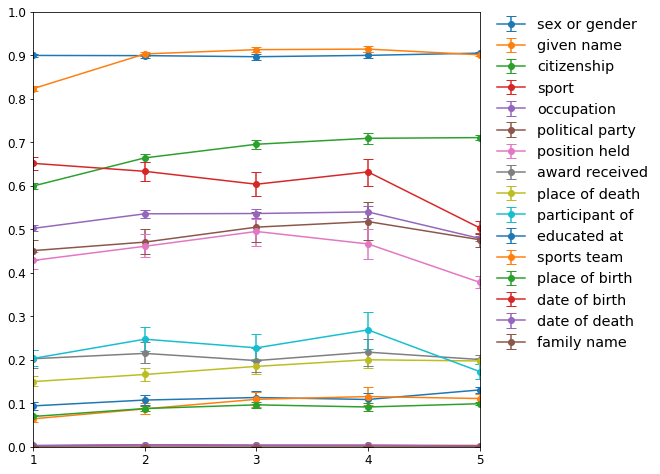

In [250]:
def plot_scores_vs_link_count_by_fact_type(df, legend=True):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    
    lines = ["-","-."]
    linecycler = cycle(lines)

    relation_order_by_perf = list(df[df['count'] == 5].sort_values('score')['fact'])
    relation_order_by_perf.reverse()
    
    for key, group in sorted(list(df.groupby('fact')), key=lambda kv: relation_order_by_perf.index(kv[0])):
        name = key.replace('<','').replace('>','').replace('_', ' ')
        name = relation_name_map.get(name, name)
        #ax.plot(group['count'], group['score'], label=name)
        
        (_, caps, _) = ax.errorbar(
            x=group['count'],
            y=group['score'],
            yerr=[group['score']-group['lower_bound'], group['upper_bound']-group['score']],
            label=name,
            capsize=5,
            fmt='-o')
        for cap in caps:
            cap.set_markeredgewidth(1)

    ax.set_xlim(1, 5)
    ax.set_ylim(0, 1)
    #plt.ylabel('Precision', fontsize='xx-large')
    #plt.xlabel('Inlink Count', fontsize='xx-large')
    plt.xticks([i for i in range(1, 5+1)], fontsize='large')
    plt.yticks([i/10 for i in range(0, 11)], fontsize='large')
    if legend:
        plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0, fontsize='x-large',frameon=False)
    plt.show()

plot_scores_vs_link_count_by_fact_type(all_entities_df)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

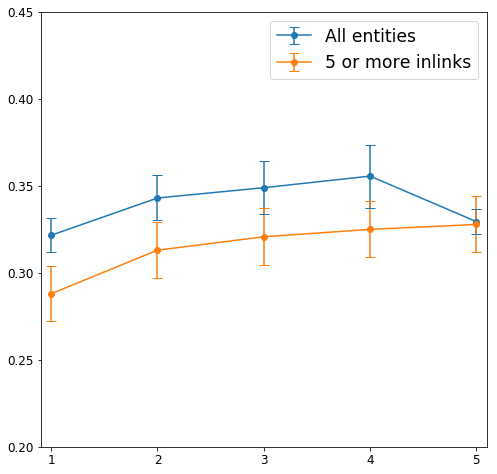

In [244]:
def plot_macro_scores_vs_link_count(dfs, legend=True):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    
    lines = ["-","-."]
    linecycler = cycle(lines)
    
    for k, df in dfs:
        group = df.groupby('count').mean()
        #ax.plot(group.index, group['score'], label=k)
        
        (_, caps, _) = ax.errorbar(
            x=group.index,
            y=group['score'],
            yerr=[group['score'] - group['lower_bound'], group['upper_bound']-group['score']],
            label=k,
            capsize=5,
            fmt='-o')

        for cap in caps:
            cap.set_markeredgewidth(1)

        ax.set_xlim(0.9, 5.1)
        ax.set_ylim(0.2, 0.4)

    #plt.ylabel('Macro Precision', fontsize='xx-large')
    #plt.xlabel('Inlink Count', fontsize='xx-large')
    plt.xticks([i for i in range(1, 5+1)], fontsize='large')
    plt.yticks([i/20 for i in range(4, 10)], fontsize='large')
    if legend:
        plt.legend(fontsize='xx-large')
    plt.show()

plot_macro_scores_vs_link_count([
    ('All entities', all_entities_df),
    ('5 or more inlinks',  subsampled_entities_df)
])

In [ ]:
metrics = evaluate_decodes(iter_entity_decodes(os.path.join(data_path, 'output.jsonl.gz')))

In [24]:
numpy.mean([len(vs) for vs in instance_sources.values()]), numpy.median([len(vs) for vs in instance_sources.values()])

(3.247980205475768, 3.0)

In [6]:
from collections import Counter
items = list(iter_items(data_path))
random.seed(1447)
random.shuffle(items)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

### Threshold

In [225]:
def get_prfs_across_thresholds(items_iter):
    scores = defaultdict(list)
    items_by_r = defaultdict(list)
    for item in items_iter:
        iid, source, relation, target, system, score = item
        items_by_r[relation].append(item)
        scores[relation].append(score)

    metrics = []
    percentiles = [p/2 for p in list(range(0, 100*2, 1))]
    for r in relation_order:
        for percentile, threshold in zip(percentiles, numpy.percentile(scores[r], percentiles)):
            tps = 0.
            fps = 0.
            fns = 0.
            for iid, source, relation, target, system, score in items_by_r[r]:
                if score >= threshold:
                    tps += 1.0 if target == system else 0.0
                    fps += 1.0 if target != system else 0.0
                else:
                    fns += 1.0

            P = 0. if tps == 0 else tps / (tps+fps)
            R = 0. if tps == 0 else tps / (tps+fns)
            F = 0. if tps == 0 else 2 * P * R / (P+R)
            metrics.append({
                'fact': r,
                'percentile': percentile,
                'threshold': threshold,
                'P': P,
                'R': R,
                'F': F
            })

    return metrics

In [230]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

def plot_pvsr_across_fact_types(df, legend=True):
    relation_order_by_perf = list(df[df['percentile'] == 0].sort_values('P')['fact'])
    relation_order_by_perf.reverse()
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    #cm = plt.get_cmap('jet')
    #ax.set_color_cycle([cm( 1.*relation_order_by_perf.index(relation_order[i]) /len(relation_order)) for i in range(len(relation_order))])

    lines = ["-","-."]
    linecycler = cycle(lines)

    for key, group in sorted(list(df.groupby('fact')), key=lambda kv: relation_order_by_perf.index(kv[0])):
        group = group.sort_values('percentile')
        name = key.replace('<','').replace('>','').replace('_', ' ')
        name = relation_name_map.get(name, name)
        ax.plot(group['R'], group['P'], label=name) #.plot(x='R', y='P',figsize=(16,8))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #plt.ylabel('Precision', fontsize='xx-large')
    #plt.xlabel('Recall', fontsize='xx-large')
    plt.xticks([i/10 for i in range(0, 11)], fontsize='large')
    plt.yticks([i/10 for i in range(0, 11)], fontsize='large')
    if legend:
        plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0, fontsize='x-large',frameon=False)
    plt.show()

In [226]:
#lnk_metrics_df = pd.DataFrame(get_prfs_across_thresholds(islice(iter_items('../data/results/mentions'), None)))
#bio_metrics_df = pd.DataFrame(get_prfs_across_thresholds(islice(iter_items('../data/results/bio'), None)))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

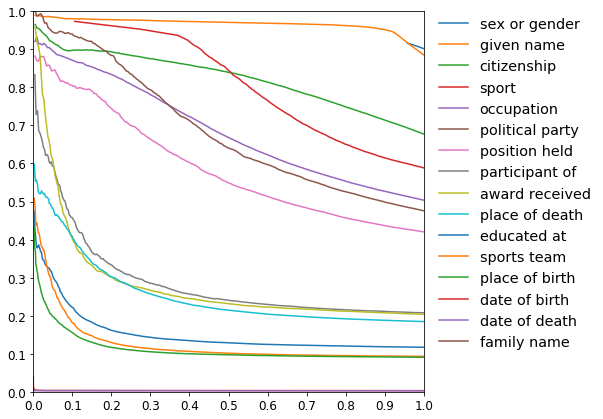

In [231]:
plot_pvsr_across_fact_types(lnk_metrics_df)

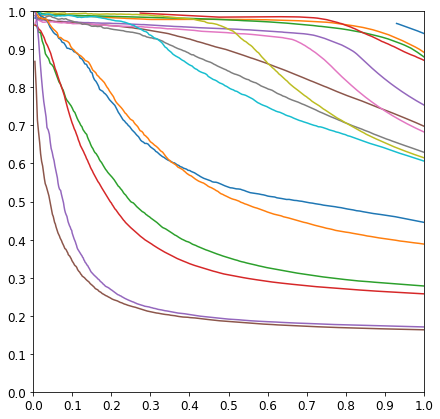

In [232]:
plot_pvsr_across_fact_types(bio_metrics_df, legend=False)

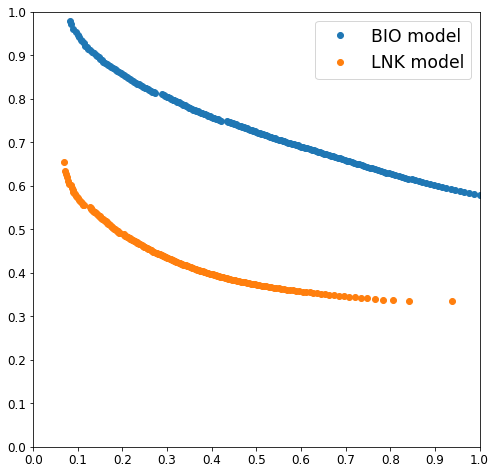

In [248]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#cm = plt.get_cmap('jet')
#ax.set_color_cycle([cm( 1.*relation_order_by_perf.index(relation_order[i]) /len(relation_order)) for i in range(len(relation_order))])


group = bio_metrics_df.groupby('percentile').mean()
ax.plot(group['R'], group['P'], 'o', label='BIO model')

group = lnk_metrics_df.groupby('percentile').mean()
ax.plot(group['R'], group['P'], 'o', label='LNK model')


ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
#plt.ylabel('Precision', fontsize='xx-large')
#plt.xlabel('Recall', fontsize='xx-large')
plt.xticks([i/10 for i in range(0, 11)], fontsize='large')
plt.yticks([i/10 for i in range(0, 11)], fontsize='large')
plt.legend(loc=0, fontsize='xx-large')
plt.show()

In [9]:
items[0]

('Pope Anianus of Alexandria',
 'in 1288 the relics of saint | anianus | - the first successors of st . mark as patriarch of alexandria - were brought to the san clemente church .',
 '<country_of_citizenship>',
 'egypt',
 'italy',
 -1.058839798)

### Date of birth Inference Analysis

In [41]:
target_years = []
system_years = []
for entity, source, relation, target, system, score in items:
    if relation == '<date_of_birth>' and system.split()[0].isdigit() and target.split()[0].isdigit():
        target_years.append(int(target.split()[0]))
        system_years.append(int(system.split()[0]))
from scipy.stats import pearsonr
pearsonr(target_years, system_years)

(0.7794332946062653, 0.0)

In [48]:
import numpy
numpy.median(numpy.abs(numpy.array(target_years) - numpy.array(system_years)))

12.0

## Explicitness Annotation

In [103]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from time import time

In [ ]:
items = list(iter_items(data_path, relation_order[:5]))

In [113]:
NUM_SAMPLES = 250
MAX_SAMPLES_PER_RELATION = NUM_SAMPLES/5

def iter_samples(samples, max_per_relation, exclude_ids, relation_counts):
    for entity, source, relation, target, system, score in samples:
        if relation_counts[relation] >= max_per_relation:
            continue
        iid = entity + ':' + relation
        if iid not in exclude_ids:
            yield {
                'id': iid,
                'entity': entity,
                'relation': relation,
                'source': source,
                'target': target,
            }
            relation_counts[relation] += 1

annotations_path = os.path.join(data_path, 'annotations.jsonl')
annotated_item_ids = set()
relation_counts = Counter()
with open(annotations_path, 'r') as f:
    for line in f:
        annotation = json.loads(line)
        annotated_item_ids.add(annotation['item']['id'])
        if annotation['annotation']['decision'] != 'error':
            relation_counts[annotation['item']['relation']] += 1

pending = list(iter_samples(items, MAX_SAMPLES_PER_RELATION, annotated_item_ids, relation_counts))
state = {
    'item': None
}

'Pending', len(pending)

('Pending', 1)

In [114]:
text_source = widgets.HTML()
text_target = widgets.HTML(layout=Layout(width='50%'))
text_relation = widgets.HTML(layout=Layout(width='50%'))
chk_interesting = widgets.Checkbox(value=False, description='Interesting?', disabled=False)

btn_decision = widgets.ToggleButtons(
    options=['Explicit', 'Justified', 'Guessable', 'Not Justified', 'Error'],
    description='Inference:',
    disabled=False,
    button_style='',
    tooltips=['', '', ''],
)

progress_text = widgets.HTML()
progress_bar = widgets.IntProgress(
    min=0,
    max=len(annotated_item_ids)+len(pending),
    step=1,
    description='Progress:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

display(widgets.VBox([
    text_source,
    text_relation,
    text_target
], layout=Layout(width='100%')))
display(chk_interesting)
display(btn_decision)
display(widgets.HBox([progress_bar, progress_text]))

def update():
    item = state['item']
    
    chk_interesting.value = False
    btn_decision.value = None
    if item:
        text_source.value = """
            <div style='margin:10px; padding: 20px;background: #eee'>""" + item['source']  + """</div>
        """
        rel_fmt = item['relation'].replace('<', '').replace('>', '').replace('_', ' ').title()
        text_relation.value = """
            <b>""" + rel_fmt + """</b>: \"""" + item['target'] + """\"
        """
    else:
        text_source.value = 'Nothing left to annotated!'
        text_relation.value=text_target.value=''

    num_completed = len(annotated_item_ids)
    progress_text.value = '[%d / %d] ' % (num_completed, num_completed+len(pending))
    progress_bar.value = num_completed

def get_next_item(state):
    if pending:
        return pending[0]

def commit():
    with open(annotations_path, 'a+') as f:
        f.write(json.dumps({
            'time': time(),
            'item': state['item'],
            'annotation': {
                'interesting': chk_interesting.value,
                'decision': btn_decision.value.lower()
            }
        }) + '\n')
        annotated_item_ids.add(state['item']['id'])

    pending.pop(0)

def transition():
    state['item'] = get_next_item(state)
    if not state['item']:
        btn_decision.disabled=True
    update()
    
def on_decision(b):
    if btn_decision.value != None and state['item']:
        commit()
        transition()

btn_decision.observe(on_decision, names='value')
transition()

VBox(children=(HTML(value=''), HTML(value='', layout=Layout(width='50%')), HTML(value='', layout=Layout(width='50%'))), layout=Layout(width='100%'))

Checkbox(value=False, description='Interesting?')

ToggleButtons(description='Inference:', options=('Explicit', 'Justified', 'Guessable', 'Not Justified', 'Error'), tooltips=['', '', ''], value='Explicit')

HBox(children=(IntProgress(value=0, description='Progress:', max=278), HTML(value='')))

In [128]:
category_map = {
    'explicit': 'explicit',
    'justified': 'reasonable',
    'guessable': 'guessable',
    'not justified': 'unjustified',
    'error': None
}

relation_counts = Counter()
stats = defaultdict(Counter)
with open(annotations_path, 'r') as f:
    for line in f:
        annotation = json.loads(line)
        relation_counts[annotation['item']['relation']] += 1
        if relation_counts[annotation['item']['relation']] <= MAX_SAMPLES_PER_RELATION:
            decision = category_map[annotation['annotation']['decision']]
            if decision is not None:
                stats[annotation['item']['relation']][decision] += 1

report_catgories = sorted(set(v for v in category_map.values() if v is not None), key=lambda c: list(category_map.values()).index(c))
print('Fact Type'.rjust(30) + ' & ' + ' & '.join((r.title() + '').rjust(15) for r in report_catgories), '\\\\')
print('\\hline\\hline')
category_agg = defaultdict(int)
category_totals = defaultdict(int)

for relation, counts in stats.items():
    report = relation.replace('<', '').replace('>', '').replace('_', ' ')
    report = report.replace('country of ', '')
    report = '\\texttt{' + report + '}'
    report = report.rjust(30)
    for c in report_catgories:
        category_agg[c] += counts[c]
        category_totals[c] += sum(counts.values())
        report += ' & ' + ('%.1f' % (counts[c]*100 / sum(counts.values()))).rjust(15)
    print(report + ' \\\\')
print('\\hline')
print('All Types'.rjust(30) + ' & ' + ' & '.join(
    ('%.1f'%(category_agg[c]*100/category_totals[c])).rjust(15) for c in report_catgories) + ' \\\\')



                     Fact Type &        Explicit &      Reasonable &       Guessable &     Unjustified \\
\hline\hline
           \texttt{given name} &            93.9 &             0.0 &             0.0 &             6.1 \\
           \texttt{occupation} &             2.2 &            46.7 &            35.6 &            15.6 \\
          \texttt{citizenship} &             6.7 &             6.7 &            20.0 &            66.7 \\
        \texttt{sex or gender} &             4.4 &            84.4 &             4.4 &             6.7 \\
        \texttt{date of birth} &             6.5 &             0.0 &             0.0 &            93.5 \\
\hline
                     All Types &            23.9 &            27.0 &            11.7 &            37.4 \\


In [5]:
from collections import Counter

items = []
with gzip.open(os.path.join(data_path, 'output.jsonl.gz'), 'rt', encoding='utf-8') as f:
    for line in tqdm(islice(f, 1000)):
        obj = json.loads(line)
        source = random.choice(obj['decode']['sources'])
        score = obj['decode']['decodes'][relation][0]['score']
        for relation, target in obj['decode']['targets'].items():
            system = ' '.join(takewhile(lambda t: t != '</s>', obj['decode']['decodes'][relation][0]['tokens']))
            if relation_order.index(relation) < 5:
                items.append((obj['instance_id'], source, relation, target, system, score))

random.seed(1447)
random.shuffle(items)

NameError: name 'data_path' is not defined

In [239]:
items = sorted(items, key=lambda i: i[-1], reverse=True)

In [240]:
items[:10]

[('Clemo',
  'the name was coined by | clemo | and popularized by kenyan rappers jua cali and nonini who started off at calif records , and is commonly sung in sheng ( slang ) , swahili',
  '<country_of_citizenship>',
  'kenya',
  'japan',
  0.0),
 ('William M. Gardner',
  'fortunately for augustus , his commanding officer , captain | william m. gardner | , testified on his behalf and prevailed on the court to suspend the harsher penalties .',
  '<sex_or_gender>',
  'male',
  'male',
  0.0),
 ('Shafik Wazzan',
  'from 1980 to 1982 , he served in the cabinet as minister of public works under president elias sarkis and prime minister | shafik wazzan | .',
  '<date_of_birth>',
  '1925 01 01',
  '1928 01 01',
  0.0),
 ('Zbigniew Beta',
  '| zbigniew beta | " "',
  '<sex_or_gender>',
  'male',
  'male',
  0.0),
 ('Georges Foucart',
  'he was the father of egyptologist | georges foucart | .',
  '<sex_or_gender>',
  'male',
  'male',
  0.0),
 ('Stephen Thomas (rugby player)',
  'wales : billy

In [241]:
for r in relation_order[:5]:
    print('\t', r)
    print()
    ris = [i for i in items if i[2] == r]
    for i in ris[:5]:
        print(i[1])
        print('\t', i[3], '=', i[4])
        print()

	 <sex_or_gender>

fortunately for augustus , his commanding officer , captain | william m. gardner | , testified on his behalf and prevailed on the court to suspend the harsher penalties .
	 male = male

| zbigniew beta | " "
	 male = male

he was the father of egyptologist | georges foucart | .
	 male = male

prior to independence , he became minister of the interior , posts and telecommunications in 1976 , as part of the transitional government headed by | abdallah mohamed kamil | .
	 male = male

van hoolwerff , as helmsman on the dutch 8 metre " hollandia " , took the 2nd place with fellow crew members : | lambertus doedes | , henk kersken , cornelis van staveren , gerard
	 male = male

	 <date_of_birth>

from 1980 to 1982 , he served in the cabinet as minister of public works under president elias sarkis and prime minister | shafik wazzan | .
	 1925 01 01 = 1928 01 01

wales : billy bancroft ( swansea ) , tom pearson ( cardiff ) , dickie garrett ( penarth ) , charlie thomas ( new